<a href="https://colab.research.google.com/github/21mad/21mad/blob/main/6-DiffusionTraining/SDXL_DreamBooth_LoRA_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Fine-tuning Stable Diffusion XL with DreamBooth and LoRA on a free-tier Colab Notebook 🧨

In this notebook, we show how to fine-tune [Stable Diffusion XL (SDXL)](https://huggingface.co/docs/diffusers/main/en/api/pipelines/stable_diffusion/stable_diffusion_xl) with [DreamBooth](https://huggingface.co/docs/diffusers/main/en/training/dreambooth) and [LoRA](https://huggingface.co/docs/diffusers/main/en/training/lora) on a T4 GPU.

SDXL consists of a much larger UNet and two text encoders that make the cross-attention context quite larger than the previous variants.

So, to pull this off, we will make use of several tricks such as gradient checkpointing, mixed-precision, and 8-bit Adam. So, hang tight and let's get started 🧪

## Setup 🪓

In [23]:
# Check the GPU
!nvidia-smi

Tue Mar 11 21:06:54 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   77C    P0             34W /   70W |     648MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [24]:
# Install dependencies.
!pip install bitsandbytes transformers accelerate peft -q

Make sure to install `diffusers` from `main`.

In [25]:
!pip install git+https://github.com/huggingface/diffusers.git -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


Download diffusers SDXL DreamBooth training script.

In [4]:
!wget https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/train_dreambooth_lora_sdxl.py

--2025-03-11 20:28:14--  https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/train_dreambooth_lora_sdxl.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84961 (83K) [text/plain]
Saving to: ‘train_dreambooth_lora_sdxl.py’

train_dreambooth_lo 100%[===================>]  82.97K  --.-KB/s    in 0.01s   

2025-03-11 20:28:14 (5.96 MB/s) - ‘train_dreambooth_lora_sdxl.py’ saved [84961/84961]



## Dataset 🐶

**Let's get our training data!**
For this example, we'll download some images from the hub

If you already have a dataset on the hub you wish to use, you can skip this part and go straight to: "Prep for
training 💻" section, where you'll simply specify the dataset name.

If your images are saved locally, and/or you want to add BLIP generated captions,
upload the file through the cell below, or upload them manually to specified directory.



In [30]:
import os

local_dir = "./cher/" #@param
os.makedirs(local_dir,exist_ok=True)

**Upload** example images from your local files. You can also upload your images manually to the speficied folder.

In [31]:
from google.colab import files

# pick a name for the image folder
os.chdir(local_dir)

# choose and upload local images into the newly created directory
uploaded_images = files.upload()
os.chdir("/content") # back to parent directory

Saving ---niagara-07sh-944-by-hiroshi-nagai_52231763183_o_result_result.jpg to ---niagara-07sh-944-by-hiroshi-nagai_52231763183_o_result_result.jpg
Saving autumn-by-hiroshi-nagai_52232346785_o_result_result.jpg to autumn-by-hiroshi-nagai_52232346785_o_result_result.jpg
Saving bronze----east-shore-by-hiroshi-nagai_52231875843_o_result_result.jpg to bronze----east-shore-by-hiroshi-nagai_52231875843_o_result_result.jpg
Saving chillside-by-hiroshi-nagai_52230597587_o_result_result.jpg to chillside-by-hiroshi-nagai_52230597587_o_result_result.jpg
Saving city-garden-by-hiroshi-nagai_52232194005_o_result_result.jpg to city-garden-by-hiroshi-nagai_52232194005_o_result_result.jpg
Saving city-highway-by-hiroshi-nagai_52231867721_o_result_result.jpg to city-highway-by-hiroshi-nagai_52231867721_o_result_result.jpg
Saving deck-by-hiroshi-nagai_52232089934_o_result_result.jpg to deck-by-hiroshi-nagai_52232089934_o_result_result.jpg
Saving eiichi-ohtaki---fall-of-sound-by-hiroshi-nagai_52230655142_o_

Preview the images:

In [37]:
from PIL import Image

def image_grid(imgs, rows, cols, resize=256):

    if resize is not None:
        imgs = [img.resize((resize, resize)) for img in imgs]
    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

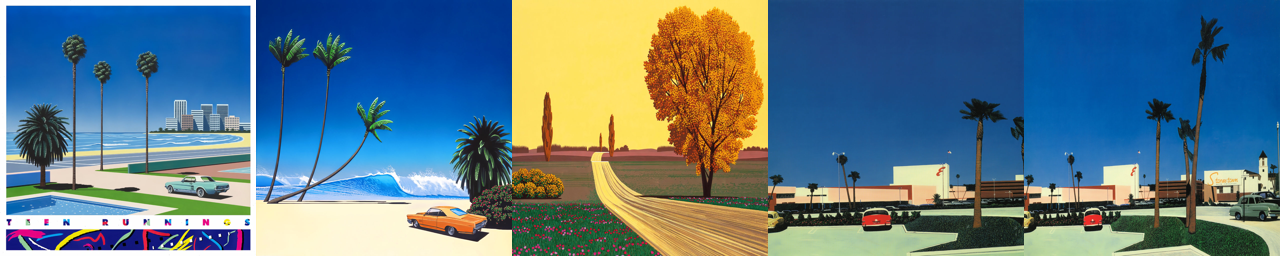

In [38]:
import glob

# change path to display images from your local dir
img_paths = "./cher/*.jpg"
imgs = [Image.open(path) for path in glob.glob(img_paths)]

num_imgs_to_preview = 5
image_grid(imgs[:num_imgs_to_preview], 1, num_imgs_to_preview)

### Generate custom captions with BLIP
Load BLIP to auto caption your images:

In [39]:
import requests
from transformers import AutoProcessor, BlipForConditionalGeneration
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

# load the processor and the captioning model
blip_processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base",torch_dtype=torch.float16).to(device)

# captioning utility
def caption_images(input_image):
    inputs = blip_processor(images=input_image, return_tensors="pt").to(device, torch.float16)
    pixel_values = inputs.pixel_values

    generated_ids = blip_model.generate(pixel_values=pixel_values, max_length=50)
    generated_caption = blip_processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return generated_caption

In [40]:
import glob
from PIL import Image

# create a list of (Pil.Image, path) pairs
local_dir = "./cher/"
imgs_and_paths = [(path,Image.open(path)) for path in glob.glob(f"{local_dir}*.jpg")]

Now let's add the concept token identifier (e.g. TOK) to each caption using a caption prefix.
Feel free to change the prefix according to the concept you're training on!
- for this example we can use "a photo of TOK," other options include:
    - For styles - "In the style of TOK"
    - For faces - "photo of a TOK person"
- You can add additional identifiers to the prefix that can help steer the model in the right direction.
-- e.g. for this example, instead of "a photo of TOK" we can use "a photo of TOK dog" / "a photo of TOK corgi dog"

In [41]:
import json

caption_prefix = "Painting in HIROSHI NAGAI retro style" #@param
with open(f'{local_dir}metadata.jsonl', 'w') as outfile:
  for img in imgs_and_paths:
      caption = caption_prefix + caption_images(img[1]).split("\n")[0]
      entry = {"file_name":img[0].split("/")[-1], "prompt": caption}
      json.dump(entry, outfile)
      outfile.write('\n')

In [42]:
!cat cher/metadata.jsonl

{"file_name": "sunshine-reggae-by-hiroshi-nagai-album-version_52231613641_o_result_result.jpg", "prompt": "Painting in HIROSHI NAGAI retro stylea painting of palm trees and a car"}
{"file_name": "impender-beach-by-hiroshi-nagai_52232131794_o_result_result.jpg", "prompt": "Painting in HIROSHI NAGAI retro stylea painting of a car parked on a beach"}
{"file_name": "autumn-by-hiroshi-nagai_52232346785_o_result_result.jpg", "prompt": "Painting in HIROSHI NAGAI retro stylea painting of a road leading to a tree"}
{"file_name": "in-the-beginning-iii-mall-by-hiroshi-nagai-upscaled_53687385928_o_result_result.jpg", "prompt": "Painting in HIROSHI NAGAI retro stylea painting of a parking lot with palm trees"}
{"file_name": "in-the-beginning-stonestown-by-hiroshi-nagai_53687168711_o_result_result.jpg", "prompt": "Painting in HIROSHI NAGAI retro stylea painting of a palm tree in a parking lot"}
{"file_name": "overview-pavement-by-hiroshi-nagai_52232204790_o_result_result.jpg", "prompt": "Painting in

Free some memory:

In [43]:
import gc

# delete the BLIP pipelines and free up some memory
del blip_processor, blip_model
gc.collect()
torch.cuda.empty_cache()

## Prep for training 💻

Initialize `accelerate`:

In [44]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!accelerate config default

Configuration already exists at /root/.cache/huggingface/accelerate/default_config.yaml, will not override. Run `accelerate config` manually or pass a different `save_location`.


### Log into your Hugging Face account
Pass [your **write** access token](https://huggingface.co/settings/tokens) so that we can push the trained checkpoints to the Hugging Face Hub:

In [46]:
from huggingface_hub import notebook_login
notebook_login()

## Train! 🔬

#### Set Hyperparameters ⚡
To ensure we can DreamBooth with LoRA on a heavy pipeline like Stable Diffusion XL, we're using:

* Gradient checkpointing (`--gradient_accumulation_steps`)
* 8-bit Adam (`--use_8bit_adam`)
* Mixed-precision training (`--mixed-precision="fp16"`)

### Launch training 🚀🚀🚀

To allow for custom captions we need to install the `datasets` library, you can skip that if you want to train solely
 with `--instance_prompt`.
In that case, specify `--instance_data_dir` instead of `--dataset_name`

In [47]:
!pip install datasets -q

 - Use `--output_dir` to specify your LoRA model repository name!
 - Use `--caption_column` to specify name of the cpation column in your dataset. In this example we used "prompt" to
 save our captions in the
 metadata file, change this according to your needs.

In [48]:
#!/usr/bin/env bash
!accelerate launch train_dreambooth_lora_sdxl.py \
  --pretrained_model_name_or_path="stabilityai/stable-diffusion-xl-base-1.0" \
  --pretrained_vae_model_name_or_path="madebyollin/sdxl-vae-fp16-fix" \
  --dataset_name="cher" \
  --output_dir="hiroshi_nagai_style_LoRA" \
  --caption_column="prompt"\
  --mixed_precision="fp16" \
  --instance_prompt="painting in HIROSHI NAGAI style" \
  --resolution=512 \
  --train_batch_size=2 \
  --gradient_accumulation_steps=3 \
  --gradient_checkpointing \
  --learning_rate=1e-4 \
  --snr_gamma=5.0 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --mixed_precision="fp16" \
  --use_8bit_adam \
  --max_train_steps=500 \
  --checkpointing_steps=250 \
  --seed="0"

2025-03-11 21:38:42.729017: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741729122.766812   19338 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741729122.779765   19338 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
03/11/2025 21:38:47 - INFO - __main__ - Distributed environment: DistributedType.NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
You are using a model of type clip_text_model to instantiate a model of type . This is not support

In [49]:
!ls cherakshin_style_LoRA

checkpoint-250	logs


### Save your model to the hub and check it out 🔥

In [50]:
from huggingface_hub import whoami
from pathlib import Path
#@markdown make sure the `output_dir` you specify here is the same as the one used for training
output_dir = "hiroshi_nagai_style_LoRA" #@param
username = whoami(token=Path("/root/.cache/huggingface/"))["name"]
repo_id = f"{username}/{output_dir}"

In [51]:
# @markdown Sometimes training finishes succesfuly (i.e. a **.safetensores** file with the LoRA weights saved properly to your local `output_dir`) but there's not enough RAM in the free tier to push the model to the hub 🙁
# @markdown
# @markdown To mitigate this, run this cell with your training arguments to make sure your model is uploaded! 🤗

# push to the hub🔥
from train_dreambooth_lora_sdxl import save_model_card
from huggingface_hub import upload_folder, create_repo

repo_id = create_repo(repo_id, exist_ok=True).repo_id

# change the params below according to your training arguments
save_model_card(
    repo_id = repo_id,
    images=[],
    base_model="stabilityai/stable-diffusion-xl-base-1.0",
    train_text_encoder=False,
    instance_prompt="photo collage in CHERKASHIN style",
    validation_prompt=None,
    repo_folder=output_dir,
    use_dora = False,
    vae_path="madebyollin/sdxl-vae-fp16-fix",
)

upload_folder(
    repo_id=repo_id,
    folder_path=output_dir,
    commit_message="End of training",
    ignore_patterns=["step_*", "epoch_*"],
)

optimizer.bin:   0%|          | 0.00/15.1M [00:00<?, ?B/s]

pytorch_lora_weights.safetensors:   0%|          | 0.00/23.4M [00:00<?, ?B/s]

scaler.pt:   0%|          | 0.00/988 [00:00<?, ?B/s]

Upload 13 LFS files:   0%|          | 0/13 [00:00<?, ?it/s]

random_states_0.pkl:   0%|          | 0.00/14.3k [00:00<?, ?B/s]

scheduler.bin:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

pytorch_lora_weights.safetensors:   0%|          | 0.00/23.4M [00:00<?, ?B/s]

optimizer.bin:   0%|          | 0.00/15.1M [00:00<?, ?B/s]

random_states_0.pkl:   0%|          | 0.00/14.3k [00:00<?, ?B/s]

scaler.pt:   0%|          | 0.00/988 [00:00<?, ?B/s]

scheduler.bin:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

events.out.tfevents.1741729207.a2651b15812f.19338.1:   0%|          | 0.00/3.32k [00:00<?, ?B/s]

events.out.tfevents.1741729207.a2651b15812f.19338.0:   0%|          | 0.00/116k [00:00<?, ?B/s]

pytorch_lora_weights.safetensors:   0%|          | 0.00/23.4M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/21mad/hiroshi_nagai_style_LoRA/commit/32b1d961f1c5412820a786a1283e5dba9e0c83bb', commit_message='End of training', commit_description='', oid='32b1d961f1c5412820a786a1283e5dba9e0c83bb', pr_url=None, repo_url=RepoUrl('https://huggingface.co/21mad/hiroshi_nagai_style_LoRA', endpoint='https://huggingface.co', repo_type='model', repo_id='21mad/hiroshi_nagai_style_LoRA'), pr_revision=None, pr_num=None)

In [52]:
from IPython.display import display, Markdown

link_to_model = f"https://huggingface.co/{repo_id}"
display(Markdown("### Your model has finished training.\nAccess it here: {}".format(link_to_model)))

### Your model has finished training.
Access it here: https://huggingface.co/21mad/hiroshi_nagai_style_LoRA

Let's generate some images with it!

## Inference 🐕

In [53]:
import torch
from diffusers import DiffusionPipeline, AutoencoderKL

vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)
pipe = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    vae=vae,
    torch_dtype=torch.float16,
    variant="fp16",
    use_safetensors=True
)
pipe.load_lora_weights(repo_id)
_ = pipe.to("cuda")

Fetching 17 files:   0%|          | 0/17 [00:00<?, ?it/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

pytorch_lora_weights.safetensors:   0%|          | 0.00/23.4M [00:00<?, ?B/s]

  0%|          | 0/25 [00:00<?, ?it/s]

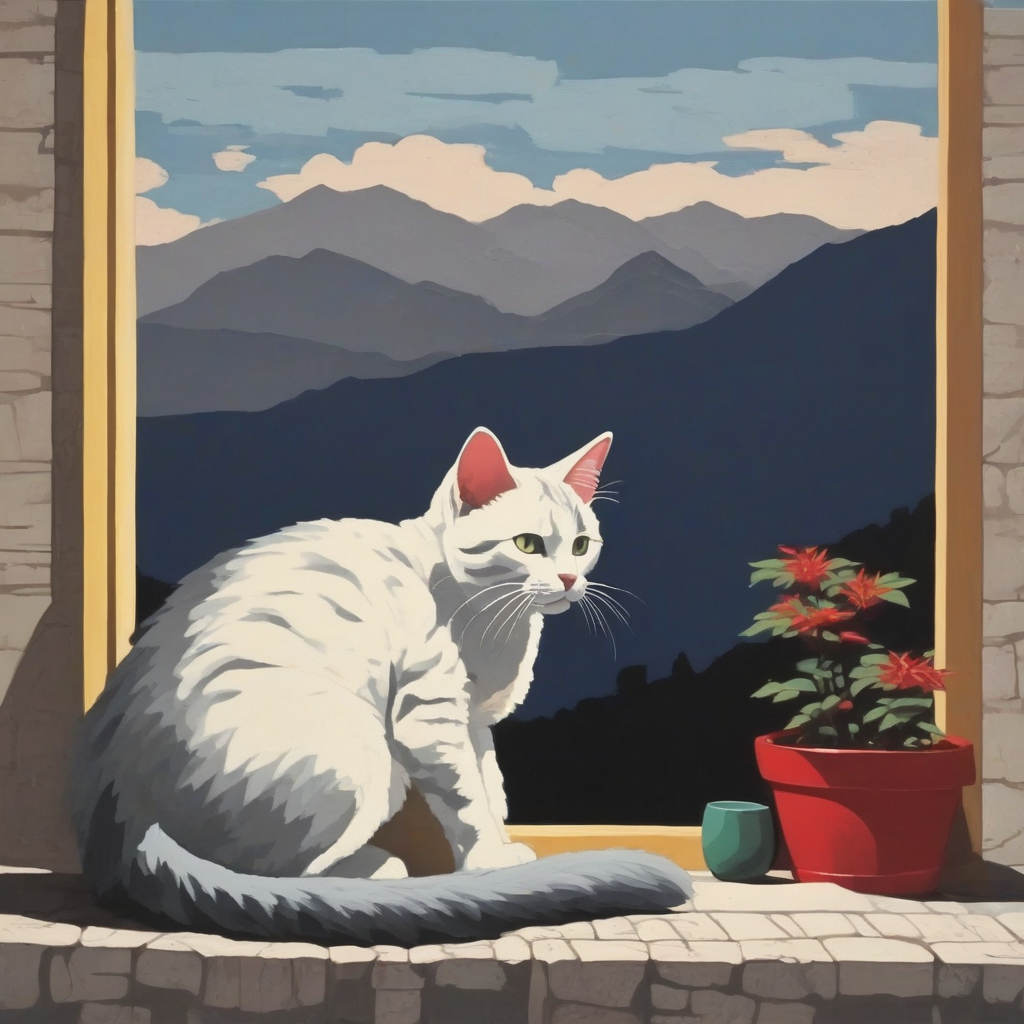

In [93]:
prompt = "Painting in HIROSHI NAGAI style, a kitten sitting with its back and looking at the mountains" # @param

image = pipe(prompt=prompt, num_inference_steps=25).images[0]
image

In [55]:
vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)
pipe = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    vae=vae,
    torch_dtype=torch.float16,
    variant="fp16",
    use_safetensors=True
)
pipe.load_lora_weights("cherakshin_style_LoRA/checkpoint-250")
pipe.fuse_lora(lora_scale=0.5)
_ = pipe.to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

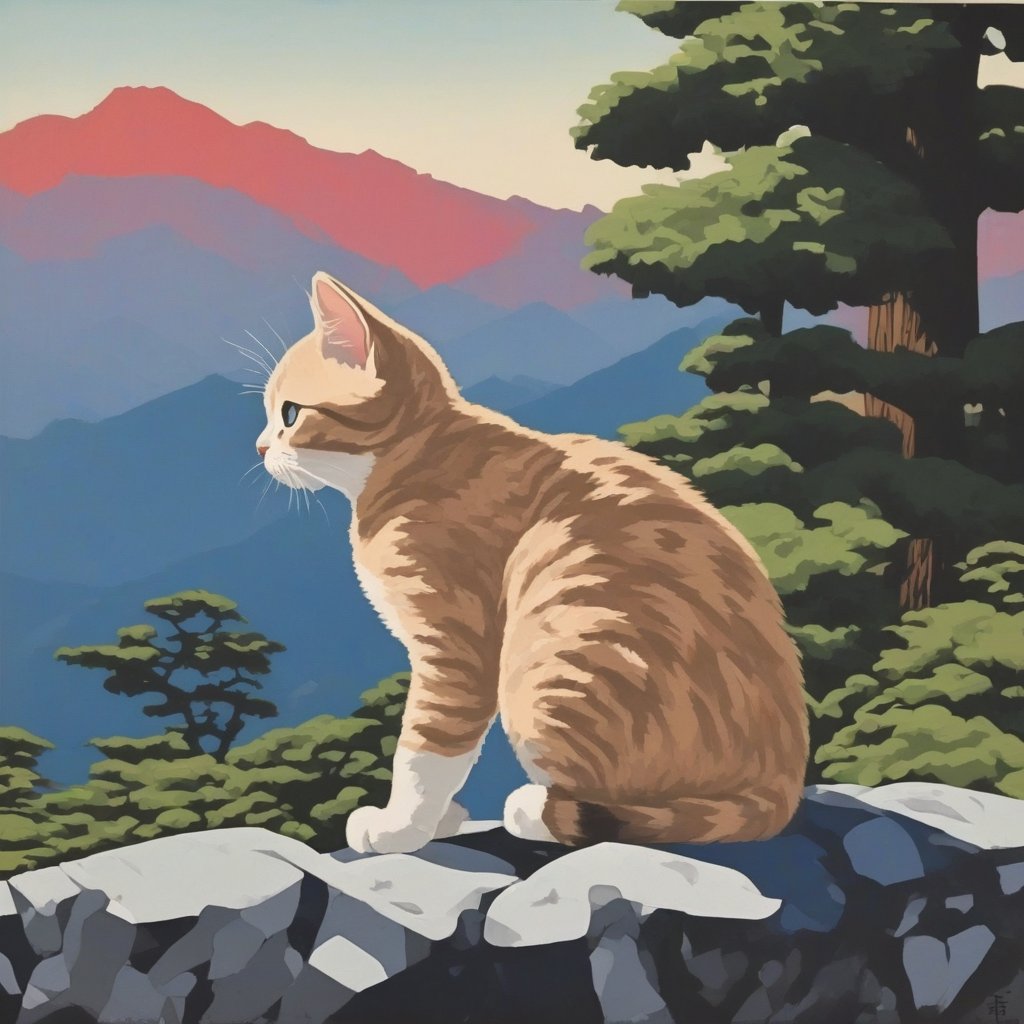

In [94]:
prompt = "Painting in HIROSHI NAGAI style, a kitten sitting with its back and looking at the mountains" # @param

image = pipe(prompt=prompt, num_inference_steps=25).images[0]
image